# Import Packages

In [21]:
# torchsummary 可以讓模型視覺化，以及匯出模型每層的詳細數量和每層的比例。
!pip install torchsummary

import pydicom
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

# Configuration

In [22]:
# TODO_1: 調整適當的參數(除了 num_classes，你可以任意調整以下的超參數)

class config:
    
    root = "/kaggle/input/deeplearninghw2"
    batch_size = 16
    lr = 4e-6
    epochs = 300
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)

device: cuda


# Input Data

In [23]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

print(train_data.head())

train_data['Stage'].value_counts().sort_index()

Number of training samples: 161
Number of testing samples: 41
        ID  Age  Gender                 FilePath  index  Stage
0  A175204   69       0  /DICOM/A175204/00010018      7      1
1  A122221   56       0  /DICOM/A122221/00010034     15      1
2   A54671   82       0   /DICOM/A54671/00010021      8      1
3   A31117   71       1   /DICOM/A31117/00010022     10      1
4  A653195   68       0  /DICOM/A653195/00010016      7      1


Stage
1    44
2    42
3    75
Name: count, dtype: int64

# Defined functions

In [24]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    # 作用是啟用 batch normalization 和 dropout。
    # 保證 BN 層能夠用到每個 batch 資料的平均值和變異數。對於 Dropout 是隨機取一部分網路連線來訓練更新參數。
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        # Pytorch 中的分類損失函數（如 CrossEntropyLoss）期望 label 為 0 開始的整數。
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    grad_norms = total_norm ** 0.5
    
    scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass , grad_norms


def validation(model, valid_loader, criterion, device):
    # 確保 BN 層能夠用全部訓練資料的平均值和變異數，即驗證過程中要保證 BN 層的平均值和變異數不變。對於 Dropout 是利用了所有網路連接，即不進行隨機捨棄神經元。
    # pytorch 會自動把 BN 和 DropOut 固定住，不會取平均，而是用訓練好的數值。
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    # TODO_2: 請將空白處填起來讓程式能夠運作。

    # 這邊禁用 PyTorch 梯度的自動計算，因為在 validation 階段我們不需要更新 model 的權重，因此不需要進行反向傳播(backpropagation)和梯度計算。
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device = device, dtype = torch.float)
            ages = ages.to(device = device, dtype = torch.float)
            genders = genders.to(device = device, dtype = torch.float)
            labels = labels.to(device = device, dtype = torch.long)

            logits = model(images, ages, genders)
            labels = torch.sub(labels, 1)  # labels 1, 2, 3 -> 0, 1, 2
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim = 1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        
        valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass

# Transformation

In [25]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min())/(image.max() - image.min())
        return changed_image

def build_transform(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    if is_train:
        # 若是包含 Random 系列的圖像增強，則只能加在train裡面
        t.append(v2.CenterCrop(size = (50, 50)))
        t.append(Normalization())
        return v2.Compose(t)
    
    t.append(v2.CenterCrop(size = (50, 50)))
    t.append(Normalization())
    return v2.Compose(t)

In [26]:
# def build_transform(is_train):
#     """
#     Create a data transformation pipeline for image preprocessing in deep learning tasks.
#     """
#     t = []
#     if is_train:
#         # 圖像增強技巧：隨機旋轉、隨機水平翻轉、隨機平移
#         t.append(v2.RandomRotation(degrees=15))  # 隨機旋轉 ±15 度
#         t.append(v2.RandomHorizontalFlip(p=0.5))  # 50% 機率水平翻轉
#         t.append(v2.CenterCrop(size=(50, 50)))
#         t.append(Normalization())
#     else:
#         t.append(v2.CenterCrop(size=(50, 50)))
#         t.append(Normalization())
        
#     return v2.Compose(t)

# Defined Dataset

In [27]:
class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode = None, transforms = None): # 將所有資料提出
        self.df = df
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x): # 找出指定的資料
        
        age = torch.tensor(self.df.iloc[x, 1]) # 年齡
        gender = torch.tensor(self.df.iloc[x, 2]) # 性別
        index = torch.tensor(self.df.iloc[x, 4]) # 起始張數
        
        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]
        
        
        
        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5]) # 標籤
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label
        
        
        # TODO_3: 寫出當 mode = valid、test 的 getitem()
        
        
        elif self.mode == "valid":
            label = torch.tensor(self.df.iloc[x, 5]) # 標籤
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label
    
        elif self.mode == "test":
            if self.transforms: image = self.transforms(image)
            return image, age, gender

In [28]:
# class ParkinsonsDataset(torch.utils.data.Dataset):
#     def __init__(self, df, mode=None, transforms=None, augment_factor=8):
#         self.df = df
#         self.mode = mode
#         self.transforms = transforms
#         self.augment_factor = augment_factor  # 設定要擴充的倍數
        
#     def __len__(self):
#         return self.df.shape[0] * self.augment_factor

#     def __getitem__(self, idx):
#         # 找到原始資料的索引
#         original_idx = idx % self.df.shape[0]
        
#         age = torch.tensor(self.df.iloc[original_idx, 1])  # 年齡
#         gender = torch.tensor(self.df.iloc[original_idx, 2])  # 性別
#         index = torch.tensor(self.df.iloc[original_idx, 4])  # 起始張數
        
#         # 影像前處理
#         image = pydicom.dcmread(config.root + self.df.iloc[original_idx, 3]).pixel_array
#         image = torch.tensor(image.astype(np.float32))
#         image = image[index-1:index+2, :, :]

#         # 進行增強
#         if self.transforms:
#             image = self.transforms(image)

#         if self.mode in ["train", "valid"]:
#             label = torch.tensor(self.df.iloc[original_idx, 5])  # 標籤
#             return image, age, gender, label
        
#         return image, age, gender

# Redefined VGG16

In [29]:
# VGG: Visual Geometry Group Network (視覺幾何群網絡)
# VGG16 的緣由: VGG 結構中有 13 個卷積層和 3 個全連接層

class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 取出 vgg16 中的特徵層
        vgg16 = models.vgg16(weights = 'IMAGENET1K_V1', progress = True) # progress = True：顯示下載進度條。
        
        # nn.Identity() 是 Pytorch 中的特殊層，不會改變輸入，只是作為佔位符。這樣你以方便修改模型結構而不會影響其整體的輸出 size
        vgg16.features[30] = nn.Identity()
        
        # 將 VGG16 的輸出特徵圖壓縮 1x1，可以得到一個 512 維的特徵向量，便於與後面的 Fully Connected Layer 結合並處理輸入的不同尺寸的圖像。
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # 移除 VGG16 預設的分類器
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值: False/True
        # features_grad: 控制是否對 VGG16 的特徵提取層進行微調(參與梯度計算)
        # 因為資料量不大，因此將 param.requires_grad 設為 False，只訓練新的分類層，減少訓練時間和 overfitting 風險。
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(512 + 2, num_classes) # 512: vgg16 特徵層結果, 2: age & gender
        )

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3), 3: labels
        return outputs

In [30]:
model = VGGplus(num_classes = 3)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)
del model

VGGplus(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

# Redefined Resnet

In [31]:
# TODO_7: 用跟 VGG 類似的方式建立 Resnet

class ResNetPlus(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False): 
        super().__init__()
        
        # Load pretrained ResNet model
        resnet = models.resnet18(weights='IMAGENET1K_V1', progress=True)
        
        # Replace the final fully connected layer with an identity layer
        resnet.fc = nn.Identity()
        
        # Set requires_grad for feature extraction layers
        for param in resnet.parameters():
            param.requires_grad = features_grad
        self.backend = resnet
        
        # Add a custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 2, num_classes)  # 512: ResNet feature output, 2: age & gender
        )

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim=1)  # Concatenate age and gender
        outputs = self.classifier(outputs)
        return outputs

In [32]:
model = ResNetPlus(num_classes = 3)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)
del model

ResNetPlus(
  (backend): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

# Redefined VIT

In [33]:
# vit
from torchvision.models import vit_b_16

class ViTplus(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False):
        super().__init__()
        
        # 1. Load pre-trained ViT model (base version with 16x16 patches)
        vit = vit_b_16(weights='IMAGENET1K_V1')

        # 2. Remove the classification head of the ViT
        vit.heads = nn.Identity()

        # 3. Freeze ViT layers if needed (based on features_grad)
        for param in vit.parameters():
            param.requires_grad = features_grad
        self.backend = vit

        # 4. Add an AdaptiveAvgPool2d layer to adjust the image size to (224, 224)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((224, 224))

        # 5. Custom classifier that combines ViT features with age and gender inputs
        self.classifier = nn.Sequential(
            nn.Linear(768 + 2, num_classes)  # 768: ViT output features, 2: age & gender
        )

    def forward(self, x, age, gender):
        # 6. Adjust input image size to (224, 224) using adaptive pooling
        x = self.adaptive_pool(x)

        # 7. Extract features using the ViT model
        output = self.backend(x)  # output size: (batch_size, 768)

        # 8. Concatenate age and gender with ViT features
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim=1)  # Concatenate along feature dimension

        # 9. Pass through the classifier to predict final classes
        outputs = self.classifier(outputs)
        return outputs

In [34]:
model = ViTplus(num_classes = 3)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)
del model

ViTplus(
  (backend): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Layer

# Run the Model

Initializing model...
Epoch[1/300], Train Loss: 1.1527, Train Acc: 26.56%, Train F1: 15.04%, Train grad: 18.71% | Valid Loss: 1.3794, Valid Acc: 30.30%, Valid F1: 15.87%, Valid Misclass: 69.70% | LR: 0.000000
Epoch[2/300], Train Loss: 1.1502, Train Acc: 27.34%, Train F1: 16.12%, Train grad: 21.64% | Valid Loss: 1.3762, Valid Acc: 30.30%, Valid F1: 15.87%, Valid Misclass: 69.70% | LR: 0.000000
Epoch[3/300], Train Loss: 1.1481, Train Acc: 28.12%, Train F1: 17.23%, Train grad: 10.74% | Valid Loss: 1.3731, Valid Acc: 30.30%, Valid F1: 15.87%, Valid Misclass: 69.70% | LR: 0.000000
Epoch[4/300], Train Loss: 1.1459, Train Acc: 28.12%, Train F1: 17.23%, Train grad: 18.92% | Valid Loss: 1.3702, Valid Acc: 30.30%, Valid F1: 15.87%, Valid Misclass: 69.70% | LR: 0.000000
Epoch[5/300], Train Loss: 1.1436, Train Acc: 29.69%, Train F1: 19.24%, Train grad: 34.31% | Valid Loss: 1.3673, Valid Acc: 33.33%, Valid F1: 20.18%, Valid Misclass: 66.67% | LR: 0.000000
Epoch[6/300], Train Loss: 1.1417, Train Acc

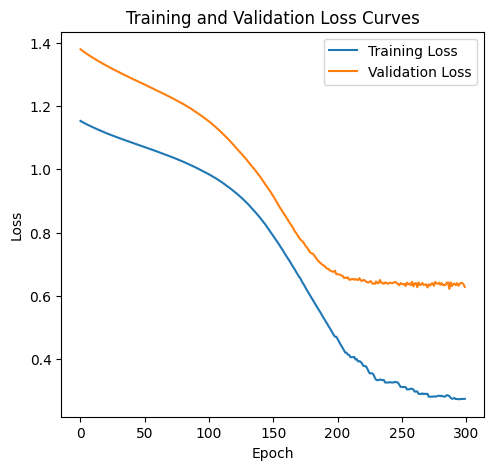

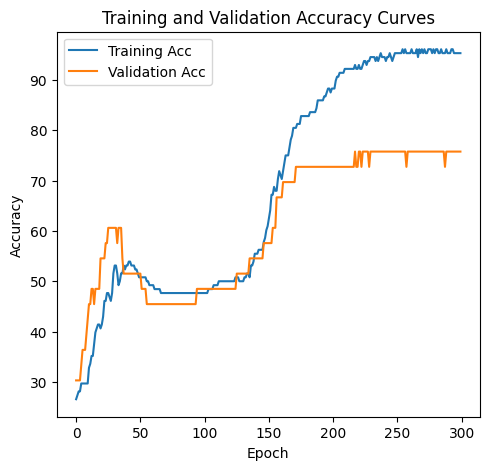

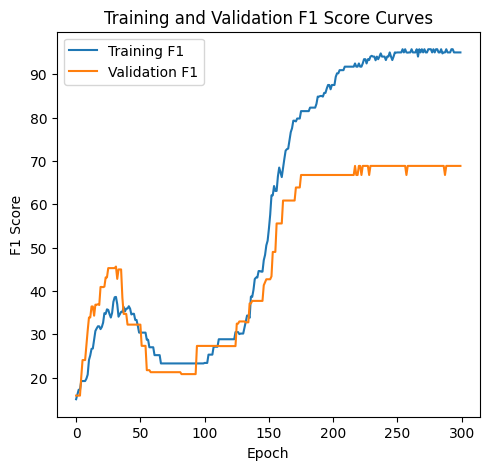

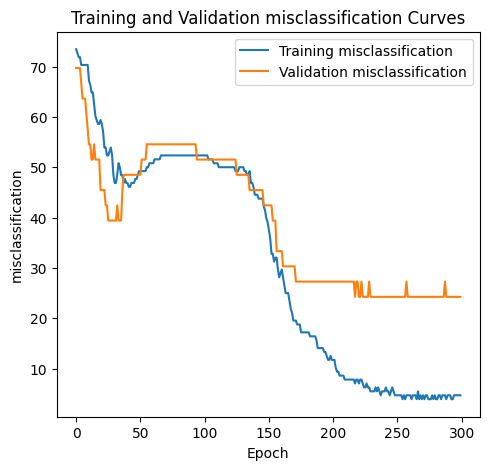

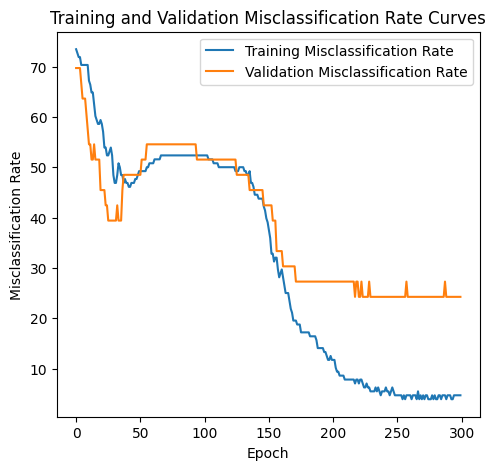

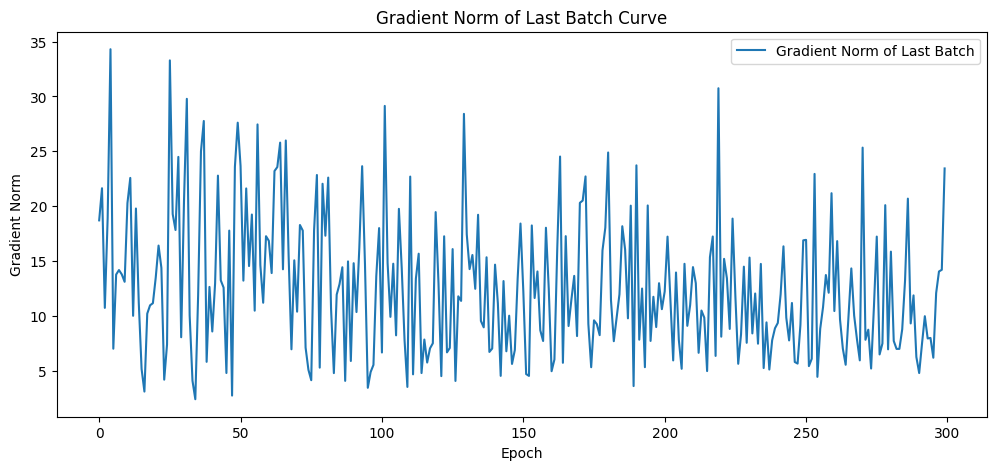

In [35]:
def main():
    seed_everything(config.seed)
    
    # train dataframe
    train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
    
    
    # TODO_4: split the training dataset，通常是 8:2，但可以嘗試其他的分法，e.g. 7:3。
    
    
    # split training & validation dataset 
    train_dataset, val_dataset = train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state = config.seed)

    train_dataset = ParkinsonsDataset(train_dataset, transforms = build_transform(True), mode = "train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms = build_transform(False), mode = "valid")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False)
    

    # settings
    print("Initializing model...")
    
    model = VGGplus(num_classes = config.num_classes, features_grad = True )
    # model = ResNetPlus(num_classes = config.num_classes, features_grad = True )
    # model = ViTplus(num_classes = config.num_classes, features_grad = True )
    
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    # TODO_5: 調整適當的 optimizer、scheduler。
#     optimizer = torch.optim.AdamW(parameters, lr=config.lr, weight_decay=config.weight_decay)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
    optimizer = torch.optim.Adam(parameters, lr = config.lr, weight_decay = config.weight_decay) 
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": [],
            "grad_norms": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass , grad_norms = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["train"]["grad_norms"].append(grad_norms)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}%, Train grad: {grad_norms:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")

        best_ckpt = torch.load("checkpoint.pth", map_location = config.device, weights_only = False)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training misclassification')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation misclassification')
    plt.xlabel('Epoch')
    plt.ylabel('misclassification')
    plt.legend()
    plt.title('Training and Validation misclassification Curves')
    plt.show()
    
    
    # TODO_6: 畫出 train 跟 valid 的 Misclassification Rate 圖。
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training Misclassification Rate')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation Misclassification Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Misclassification Rate')
    plt.legend()
    plt.title('Training and Validation Misclassification Rate Curves')
    plt.show()
    
    # Plot gradient norms of the last batch
    plt.figure(figsize=(12, 5))
    plt.plot(range(config.epochs), history["train"]["grad_norms"], label='Gradient Norm of Last Batch')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.title('Gradient Norm of Last Batch Curve')
    plt.show()
   
    

if __name__ == "__main__":
    main()

In [36]:
print(os.path.isfile('checkpoint.pth'))

True


# testing

In [37]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad(): 
        for image, age, gender in test_loader:
            image = image.to(device = device, dtype = torch.float)
            age = age.to(device)
            gender = gender.to(device)
            logits = model(image, age, gender)
            pred = torch.argmax(logits, dim = 1)
            preds.append(pred)

    preds = torch.cat(preds)
    
    # TODO_8: 因為輸出的 preds為 0,1,2，所以請調整成 1,2,3。
    preds = preds + 1
    
    return preds

In [38]:
seed_everything(config.seed)
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

# TODO_9: 填寫 test_dataset、test_loader、model 四個空格，記得 test_loader 的 shuffle = False。

test_dataset = ParkinsonsDataset(test_data, transforms = build_transform(False), mode = "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config.batch_size, shuffle = False)
model = VGGplus(num_classes = config.num_classes)


model.to(config.device)

best_ckpt = torch.load(f"checkpoint.pth")
model.load_state_dict(best_ckpt["model"])

preds = testing(model, test_loader, config.device)

In [39]:
# TODO_10: 將 .csv 取名。

df = pd.read_csv(os.path.join(config.root, 'submission.csv'))
df = pd.DataFrame(df)
df['Stage'] = preds.cpu().numpy() # 將 preds 從 GPU 轉移到 CPU 並轉換為 NumPy 陣列
df.to_csv('test.csv',index = False, header = True)

In [40]:
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)

總參數量: 14716233
